In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import time
import random
import os

import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.metrics import r2_score

In [2]:
cd '/Volumes/GoogleDrive/My Drive/Skoltech/Research/Hydrogen Oxidation/'

/Volumes/GoogleDrive/My Drive/Skoltech/Research/Hydrogen Oxidation


# Utils

## Dataset

In [3]:
class OxidationDataset(Dataset):

    def __init__(self, inputs_path, outputs_dir, nsample, ntimesteps):
        """
        Args:
            inputs_dir (string): 
            outputs_dir (string):
        """
        
        # x = np.loadtxt(inputs_path, skiprows = 1, delimiter= ',')
        x = np.loadtxt(inputs_path, delimiter= ' ')
        #drop inert gases
        self.inputs = np.delete(x[ :nsample, :], [8,9], 1)[:, np.newaxis]
        self.out_dir = outputs_dir
        self.ntimesteps = ntimesteps


    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        #get output
        Y = np.loadtxt(os.path.join(self.out_dir, f'out{idx}.txt'), delimiter= ';')
        
        #drop inert gases
        if type(self.ntimesteps) == int:
            Y = Y[:self.ntimesteps, 1:-2]
        elif type(self.ntimesteps) == list:
            Y = Y[self.ntimesteps, 1:-2]
        elif self.ntimesteps == 'all':
            Y = Y[:, 1:-2]
        else:
            raise ValueError("Invalid argument 'ntimestep' should an interger, a list or 'all' string")

        return torch.from_numpy(self.inputs[idx]), torch.from_numpy(Y)

## Transformation

In [4]:
#for data standardization
def standardize(tensor, dim = 0, mean = None, std = None) -> torch.float64:
    tensor = tensor.float()
    
    if mean is None:
        mean = tensor.mean(dim = dim, keepdim = True)
    
    if std is None:
        std = tensor.std(dim = dim, keepdim = True)

    standard_tensor = (tensor - mean) / std
    return standard_tensor, mean, std

def inverse_standardize(tensor, dim, mean, std):
    tensor = tensor.float()
    return tensor * std + mean

## Data Loaders

In [5]:
def loaders(batch_size, ntimesteps, nsample, split):
    '''
    batch_size: int = batch size
    ntimesteps: int or list = number/list of time steps in data
    nsample: int = number of samples to use
    split: list = list of train set to data ration and train+valid set to data ratio
    '''
    #initialize dataset object
    dataset = OxidationDataset(inputs_path = 'input_98660.txt',
                               outputs_dir = './Out_files_98660',
                               nsample = nsample,
                               ntimesteps = ntimesteps)
    # Creating Training, Validation, and Test dataloaders
    # split Train : Val : Test = 0.7 : 0.2 : 0.1
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    train_split = int(np.floor(split[0] * dataset_size))
    val_split = int(np.floor(split[1] * dataset_size))
    shuffle_dataset = True
    random_seed = 42
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices = indices[ : train_split]
    val_indices = indices[train_split : val_split]
    test_indices = indices[val_split : ]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    return train_loader, validation_loader, test_loader

## Inference

In [6]:
def run_inference(model, dataloader):
    output_stack = []
    predict_stack = []
    total_duration = 0

    for i, (input, output) in enumerate(dataloader):
        if torch.cuda.is_available():
            input, output = input.cuda(), output.cuda()

        #standardize
        start = time.time()
        input, _, _ = standardize(input, 0, torch.tensor(mean_std_dict['mean_x']), torch.tensor(mean_std_dict['std_x']))
        pred = model(input.float())
        pred = inverse_standardize(pred, 0, torch.tensor(mean_std_dict['mean_y']), torch.tensor(mean_std_dict['std_y']))
        duration = time.time() - start
        total_duration += duration

        #stack results
        predict_stack.append(pred)
        output_stack.append(output)

    error = torch.linalg.norm(torch.concat(output_stack) - torch.concat(predict_stack))/torch.linalg.norm(torch.concat(output_stack))
    
    return total_duration, error

# Singular time estimations

## Load Data

In [7]:
#Model Architecture
class RNN_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, dropout = 0.1, batch_first = True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.linear(out)
        return out

In [8]:
#get data loaders
batch_size = 64
ntimesteps = [-1]
nsample = 1000
split = [0.5, 0.9]
train_loader, _, _ = loaders(batch_size, ntimesteps, nsample, split)

#check
for x,y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 1, 10]) torch.Size([64, 1, 9])


In [9]:
#initialize the model
input_size = 10
hidden_size = 32
num_layers = 2
output_size = 9
model = RNN_Model(input_size, hidden_size, num_layers, output_size)
model

RNN_Model(
  (rnn): RNN(10, 32, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=32, out_features=9, bias=True)
)

In [10]:
#get means and stds
with open('rnn_mean_std.json', 'r') as f:
    mean_std_dict = json.load(f)

In [11]:
model.load_state_dict(torch.load('./Models/rnn.pth',
                                 map_location=torch.device('cpu')))
if torch.cuda.is_available():
    model = model.cuda()
    for i in mean_std_dict.keys():
        mean_std_dict[i] = mean_std_dict[i].cuda()

model.eval()
timers = []
for _ in range(20):
    total_duration, _ = run_inference(model, train_loader)
    timers.append(total_duration)
# print(f'Duration: {total_duration},\nNormalized Error: {error}')

np.mean(timers)

0.01945505142211914

# 5 time estimations

In [12]:
#model architecture:::one to many RNN architechture
class Base_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Base_RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, dropout = 0.1, batch_first = True)
        self.linear = nn.Linear(self.hidden_size, self.input_size)
        
    def forward(self, x, in_hidden = None):
        if in_hidden == None:
            out, out_hidden = self.rnn(x)
        else:
            out, out_hidden = self.rnn(x, in_hidden)
        out = self.linear(out)
        return out, out_hidden
    
class RNN_Model_Multiple(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size, ntimesteps):
        super(RNN_Model_Multiple, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.ntimesteps = ntimesteps
        self.base_rnn = Base_RNN(self.input_size, self.hidden_size, self.num_layers)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.input_size, self.output_size)
        
    def forward(self, x):
        out = x
        hidden = None
        
        #to store outputs
        outputs = []
        
        for t in range(self.ntimesteps):                
            #pass to rnn
            out, hidden = self.base_rnn(out, hidden)
            #pass to output layer
            outputs.append(self.linear(self.relu(out)))
            #skip connection
            out += x

        return torch.concat(outputs, 1)


In [13]:
#initialize dataset object
# batch_size = 64
ntimesteps = [0, 20, 50, 100, -1]
nsample = 1000
split = [0.5, 0.9]
train_loader, _, _ = loaders(batch_size, ntimesteps, nsample, split)

#check
for x,y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 1, 10]) torch.Size([64, 5, 9])


In [14]:
#initialize the model
input_size = 10
hidden_size = 32
num_layers = 2
output_size = 9
ntimesteps = 5
model = RNN_Model_Multiple(input_size, hidden_size, num_layers, output_size, ntimesteps)
model

RNN_Model_Multiple(
  (base_rnn): Base_RNN(
    (rnn): RNN(10, 32, num_layers=2, batch_first=True, dropout=0.1)
    (linear): Linear(in_features=32, out_features=10, bias=True)
  )
  (relu): ReLU()
  (linear): Linear(in_features=10, out_features=9, bias=True)
)

In [15]:
#get means and stds
with open('rnn_5_mean_std.json', 'r') as f:
    mean_std_dict = json.load(f)

In [16]:
model.load_state_dict(torch.load('./Models/best_rnn_5.pth',
                                 map_location=torch.device('cpu')))
if torch.cuda.is_available():
    model = model.cuda()
    for i in mean_std_dict.keys():
        mean_std_dict[i] = mean_std_dict[i].cuda()

model.eval()
timers = []
for _ in range(20):
    total_duration, _ = run_inference(model, train_loader)
    timers.append(total_duration)
# print(f'Duration: {total_duration},\nNormalized Error: {error}')

np.mean(timers)

0.032682943344116214

# Complete time estimation

In [17]:
#initialize dataset object
# batch_size = 64
ntimesteps = 'all'
nsample = 1000
split = [0.5, 0.9]
train_loader, _, _ = loaders(batch_size, ntimesteps, nsample, split)

#check
for x,y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 1, 10]) torch.Size([64, 201, 9])


In [18]:
#initialize the model
input_size = 10
hidden_size = 32
num_layers = 2
output_size = 9
ntimesteps = 201
model = RNN_Model_Multiple(input_size, hidden_size, num_layers, output_size, ntimesteps)
# model.apply(init_weights)
model

RNN_Model_Multiple(
  (base_rnn): Base_RNN(
    (rnn): RNN(10, 32, num_layers=2, batch_first=True, dropout=0.1)
    (linear): Linear(in_features=32, out_features=10, bias=True)
  )
  (relu): ReLU()
  (linear): Linear(in_features=10, out_features=9, bias=True)
)

In [19]:
with open('rnn_all_mean_std.json', 'r') as f:
    mean_std_dict = json.load(f)

In [20]:
model.load_state_dict(torch.load('./Models/best_rnn_all.pth',
                                 map_location=torch.device('cpu')))
if torch.cuda.is_available():
    model = model.cuda()
    for i in mean_std_dict.keys():
        mean_std_dict[i] = mean_std_dict[i].cuda()

model.eval()
timers = []
for _ in range(20):
    total_duration, _ = run_inference(model, train_loader)
    timers.append(total_duration)
# print(f'Duration: {total_duration},\nNormalized Error: {error}')

np.mean(timers)

0.5481042504310608

## Result visualization

In [137]:
df = pd.read_csv('RNN Times.csv', index_col=0)#header= ['Batch Size', 'RNN for one time step', 'RNN for 5 time steps', 'RNN for all time steps'])
df.loc['No batch','chemical_box program'] = 18.07788202
df.rename(columns= {'R1': 'RNN for one time step',
                   'R5': 'RNN for 5 time steps',
                   'R201': 'RNN for all time steps'}, inplace = True)
df

,RNN for one time step,RNN for 5 time steps,RNN for all time steps,chemical_box program
Batch size,,,,
64,0.005450,0.009279,0.494376,NaN
32,0.014056,0.019663,1.047822,NaN
16,0.015103,0.033406,1.518657,NaN
8,0.029780,0.065624,2.902060,NaN
No batch,NaN,NaN,NaN,18.077882


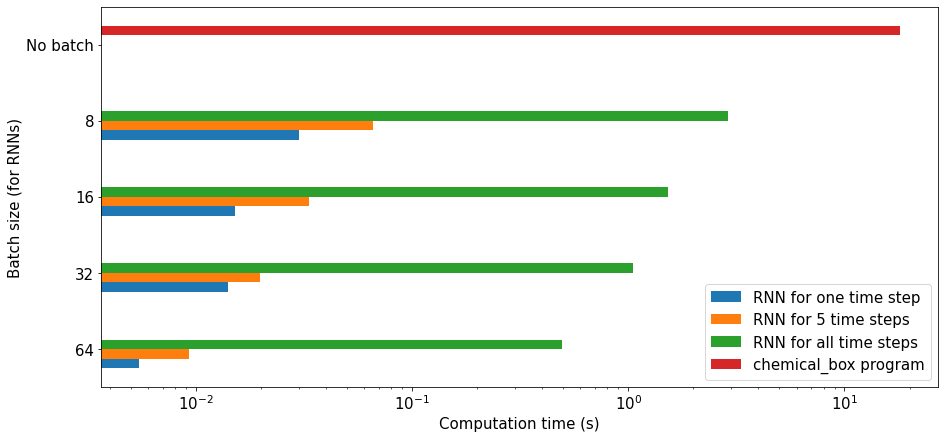

In [139]:
df.plot.barh(figsize=(15,7), logx =True, fontsize = 15)
plt.xlabel('Computation time (s)', fontsize = 15)
plt.ylabel('Batch size (for RNNs)', fontsize = 15)
plt.legend(fontsize = 15)

In [174]:
n_batch = [8,16,32, 63]
df['RNN for one time step'].iloc[:-1]/np.array(n_batch)/np.array(batch_size)

Batch size
64    0.000011
32    0.000027
16    0.000029
8     0.000059
Name: RNN for one time step, dtype: float64

In [175]:
df['RNN for one time step'].iloc[:-1]/500

Batch size
64    0.000011
32    0.000028
16    0.000030
8     0.000060
Name: RNN for one time step, dtype: float64

Text(0.5, 1.0, 'Average Computation Time')

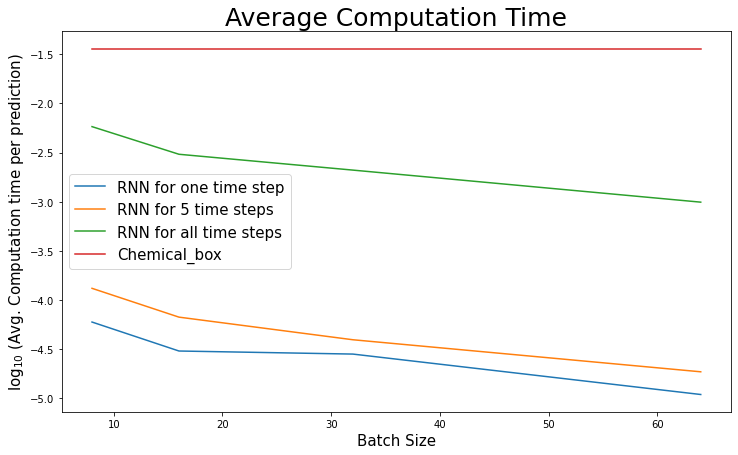

In [173]:
batch_size = [64,32,16,8]
plt.figure(figsize=(12,7))
plt.plot(batch_size, np.log10(df['RNN for one time step'].iloc[:-1]/500), label = 'RNN for one time step')
plt.plot(batch_size, np.log10(df['RNN for 5 time steps'].iloc[:-1]/500), label = 'RNN for 5 time steps')
plt.plot(batch_size, np.log10(df['RNN for all time steps'].iloc[:-1]/500), label = 'RNN for all time steps')
plt.plot(batch_size, np.log10([18.07788202/500 for i in range(4)]), label = 'Chemical_box')
plt.legend(fontsize = 15)
plt.xlabel('Batch Size', fontsize= 15)
plt.ylabel('log$_{10}$ (Avg. Computation time per prediction)', fontsize= 15)
plt.title('Average Computation Time', fontsize = 25)